Hunter Bennett | Glass Lab | Kupffer Strains Project | February 24 2021  

This notebook is for making fancier figure level plots describing differential gene expression for the strains NASH paper. It generates the following plots:
1. Differential scatter plot similar to those make in Link et al. 2018 showing differential peaks at fc > 2 and fc > 4.

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffgene, pull_comparisons_get_diff

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [4]:
dataDirectory = '../A00_Strains_Control_WholeLiver_RNA/'
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for "fancy figures" for manuscript

In [5]:
if not os.path.isdir('./fancy_figures/'):
    os.mkdir('./fancy_figures/')

### Import differential peaks

In [6]:
diff, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
    '../A00_Strains_Control_WholeLiver_RNA/differential/aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt',
    '../A00_Strains_Control_WholeLiver_RNA/expression/HOMER.rawTPM.txt')

ge all transcripts (24940, 43)
Diff Gene selected transcripts (5501, 14)
ge selected transcripts (5501, 43)


# Set parameters that don't change throughout plotting

In [7]:
os.listdir(dataDirectory+'/differential/')

['aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt',
 'aj_stellate_control_young.vs.c57_stellate_control_young.scatter.txt',
 'aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.pdf',
 'overall.heatmap.txt',
 'aj_lsec_control_young.vs.balbc_lsec_control_young.scatter.pdf',
 'aj_stellate_control_young.vs.balbc_stellate_control_young.scatter.txt',
 'c57_stellate_control_young.vs.balbc_stellate_control_young.scatter.pdf',
 'c57_lsec_control_young.vs.aj_lsec_control_young.scatter.homer.txt',
 'c57_lsec_control_young.vs.balbc_lsec_control_young.scatter.pdf',
 'aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.txt',
 'balbc_lsec_control_young.vs.aj_lsec_control_young.scatter.homer.txt',
 'balbc_lsec_control_young.vs.c57_lsec_control_young.scatter.txt',
 'c57_stellate_control_young.vs.aj_stellate_control_young.scatter.pdf',
 'c57_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.txt',
 'c57_lsec_control_young.vs.aj_lsec_control_

In [8]:
         'aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt',
         'aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
         'balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt'

'balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt'

In [9]:
comps = ['aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt',
         'aj_hepatocyte_control_young.vs.c57_hepatocyte_control_young.scatter.homer.txt',
         'balbc_hepatocyte_control_young.vs.c57_hepatocyte_control_young.scatter.homer.txt',
         'aj_lsec_control_young.vs.balbc_lsec_control_young.scatter.homer.txt',
         'aj_lsec_control_young.vs.c57_lsec_control_young.scatter.homer.txt',
         'balbc_lsec_control_young.vs.c57_lsec_control_young.scatter.homer.txt',
         'aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt',
         'aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
         'balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
         'aj_stellate_control_young.vs.balbc_stellate_control_young.scatter.homer.txt',
         'aj_stellate_control_young.vs.c57_stellate_control_young.scatter.homer.txt',
         'balbc_stellate_control_young.vs.c57_stellate_control_young.scatter.homer.txt']

ids = [['AJ.*Hep', 'BALB.*Hep'],
       ['AJ.*Hep', 'C57.*Hep'],
       ['BALB.*Hep', 'C57.*Hep'],
       ['AJ.*LSEC', 'BALB.*LSEC'],
       ['AJ.*LSEC', 'C57.*LSEC'],
       ['BALB.*LSEC', 'C57.*LSEC'],
       ['AJ.*Stellate', 'BALB.*Stellate'],
       ['AJ.*Stellate', 'C57.*Stellate'],
       ['BALB.*Stellate', 'C57.*Stellate']]

labels = ['aj_vs_balb',
          'aj_vs_c57',
          'balbc_vs_c57']

colors = [['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26']]

# set plotting thresholds
pthresh = 0.05
fontsize=8
labelsize=6
lfcthresh = (1,2)
dotsize = 0.5
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'
filename='kupffer_niche_rna_scatter_label_small.png'

In [10]:
n_diff_genes_list = []
n_diff_genes_dict = {}
for comp in comps:

    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        dataDirectory+'./differential/'+comp,
        dataDirectory+'./expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    print(comp, 'N diff genes:', ((de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])).sum())
    
    n_diff_genes_list.append(((de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])).sum())
    n_diff_genes_dict[comp.split('.scatter')[0]] = ((de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])).sum()

ge all transcripts (24940, 43)
Diff Gene selected transcripts (5501, 14)
ge selected transcripts (5501, 43)
aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young.scatter.homer.txt N diff genes: 269
ge all transcripts (24940, 43)
Diff Gene selected transcripts (5494, 14)
ge selected transcripts (5494, 43)
aj_hepatocyte_control_young.vs.c57_hepatocyte_control_young.scatter.homer.txt N diff genes: 177
ge all transcripts (24940, 43)
Diff Gene selected transcripts (5650, 14)
ge selected transcripts (5650, 43)
balbc_hepatocyte_control_young.vs.c57_hepatocyte_control_young.scatter.homer.txt N diff genes: 432
ge all transcripts (24940, 43)
Diff Gene selected transcripts (8926, 14)
ge selected transcripts (8926, 43)
aj_lsec_control_young.vs.balbc_lsec_control_young.scatter.homer.txt N diff genes: 174
ge all transcripts (24940, 43)
Diff Gene selected transcripts (8952, 14)
ge selected transcripts (8952, 43)
aj_lsec_control_young.vs.c57_lsec_control_young.scatter.homer.txt N diff genes: 3

In [13]:
pd.Series(n_diff_genes_dict)

aj_hepatocyte_control_young.vs.balbc_hepatocyte_control_young     269
aj_hepatocyte_control_young.vs.c57_hepatocyte_control_young       177
balbc_hepatocyte_control_young.vs.c57_hepatocyte_control_young    432
aj_lsec_control_young.vs.balbc_lsec_control_young                 174
aj_lsec_control_young.vs.c57_lsec_control_young                   324
balbc_lsec_control_young.vs.c57_lsec_control_young                296
aj_kupffer_control_young.vs.balbc_kupffer_control_young           191
aj_kupffer_control_young.vs.c57_kupffer_control_young             284
balbc_kupffer_control_young.vs.c57_kupffer_control_young          359
aj_stellate_control_young.vs.balbc_stellate_control_young         708
aj_stellate_control_young.vs.c57_stellate_control_young           549
balbc_stellate_control_young.vs.c57_stellate_control_young        763
dtype: int64

In [44]:
diff_gene_frame = pd.DataFrame(np.array(n_diff_genes_list).reshape(4,3),
                               index=['Hepatocytes', 'Kupffer Cells', 'LSECs', 'Stellate Cells'],
                               columns=['AJ vs. BALB', 'AJ vs. C57', 'BALB vs. C57']).T

In [45]:
diff_gene_frame

,Hepatocytes,Kupffer Cells,LSECs,Stellate Cells
AJ vs. BALB,269,174,191,708
AJ vs. C57,177,324,284,549
BALB vs. C57,432,296,359,763


In [46]:
diff_gene_frame['million_muts'] = pd.Series({'AJ vs. BALB': 2.37,
                                             'AJ vs. C57': 4.40,
                                             'BALB vs. C57':4.74})

In [47]:
diff_gene_frame

,Hepatocytes,Kupffer Cells,LSECs,Stellate Cells,million_muts
AJ vs. BALB,269,174,191,708,2.37
AJ vs. C57,177,324,284,549,4.40
BALB vs. C57,432,296,359,763,4.74


In [84]:
s=5

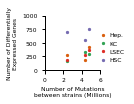

In [93]:
fig, ax = plt.subplots(figsize=(1,1))

ax.scatter(diff_gene_frame.million_muts,
           diff_gene_frame.loc[:, 'Hepatocytes'],
           s=s,
           c='#d95f0e',
           label='Hep.')
ax.scatter(diff_gene_frame.million_muts,
           diff_gene_frame.loc[:, 'Kupffer Cells'],
           s=s,
           c='#31a354',
           label='KC')
ax.scatter(diff_gene_frame.million_muts,
           diff_gene_frame.loc[:, 'LSECs'],
           s=s,
           c='#de2d26',
           label='LSEC')
ax.scatter(diff_gene_frame.million_muts,
           diff_gene_frame.loc[:, 'Stellate Cells'],
           s=s,
           c='#756bb1',
           label='HSC')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_xlim(0, 6)
ax.set_ylim(0,1000)
ax.set_xlabel('Number of Mutations\nbetween strains (Millions)')
ax.set_ylabel('Number of Differentially\nExpressed Genes')
ax.legend(fontsize=6,markerscale=1, frameon=False, ncol=1, loc=(0.9,0.1),
          handletextpad=0.05, columnspacing=0.05)

plt.savefig('./fancy_figures/mutational_burden_correlation.pdf',
            bbox_inches='tight')